Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [3]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [4]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [5]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [6]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

## Data Exploration

In [7]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,...,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [8]:
df.shape

(421, 59)

In [9]:
df.isnull().sum().sort_values(ascending = True)

Burrito             0
Tortilla            0
Great               0
Date                0
Synergy             2
Uniformity          2
Hunger              3
Wrap                3
Fillings            3
Cost                7
Meat:filling        9
Meat               14
Temp               20
Salsa              25
Length            138
Circum            140
Volume            140
Beef              242
Cheese            262
Pico              263
Guac              267
Fries             294
Sour cream        329
Yelp              334
Google            334
Pork              370
Sauce             383
Rice              385
Beans             386
Unreliable        388
Chips             395
Density (g/mL)    399
Mass (g)          399
Chicken           400
Shrimp            400
Onion             404
Cilantro          406
Avocado           408
Lettuce           410
Cabbage           413
Bell peper        414
Salsa.1           414
NonSD             414
Pineapple         414
Tomato            414
Fish      

In [10]:
df.describe(include = 'number')

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,87.000000,87.000000,414.000000,418.000000,22.000000,22.000000,283.000000,281.000000,281.000000,421.000000,401.000000,407.000000,418.000000,412.000000,419.000000,396.000000,419.000000,418.000000,0.0
mean,3.887356,4.167816,7.067343,3.495335,546.181818,0.675277,20.038233,22.135765,0.786477,3.519477,3.783042,3.620393,3.539833,3.586481,3.428998,3.371970,3.586993,3.979904,NaN
std,0.475396,0.373698,1.506742,0.812069,144.445619,0.080468,2.083518,1.779408,0.152531,0.794438,0.980338,0.829254,0.799549,0.997057,1.068794,0.924037,0.886807,1.118185,NaN
min,2.500000,2.900000,2.990000,0.500000,350.000000,0.560000,15.000000,17.000000,0.400000,1.000000,1.000000,1.000000,1.000000,0.500000,0.000000,0.000000,1.000000,0.000000,NaN
25%,3.500000,4.000000,6.250000,3.000000,450.000000,0.619485,18.500000,21.000000,0.680000,3.000000,3.000000,3.000000,3.000000,3.000000,2.600000,3.000000,3.000000,3.500000,NaN
50%,4.000000,4.200000,6.990000,3.500000,540.000000,0.658099,20.000000,22.000000,0.770000,3.500000,4.000000,3.800000,3.500000,4.000000,3.500000,3.500000,3.800000,4.000000,NaN
75%,4.000000,4.400000,7.880000,4.000000,595.000000,0.721726,21.500000,23.000000,0.880000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN
max,4.500000,5.000000,25.000000,5.000000,925.000000,0.865672,26.000000,29.000000,1.540000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [11]:
df.describe(exclude = 'number')

,Burrito,Date,Chips,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,...,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
count,421,421,26,33,7,179,158,154,159,127,...,4,1,5,3,3,2,13,3,1,421
unique,5,169,4,1,2,2,2,2,2,2,...,1,1,1,1,1,1,1,2,1,2
top,California,8/30/2016,x,x,x,x,x,x,x,x,...,x,x,x,x,x,x,x,x,x,False
freq,169,29,21,33,5,137,127,114,128,102,...,4,1,5,3,3,2,13,2,1,239


**Drop null values**
I will drop columns with na's over a certain threshold

In [12]:
thresh = len(df) * .2
thresh
#Came up with this number after doing some googling
#https://discuss.analyticsvidhya.com/t/what-should-be-the-allowed-percentage-of-missing-values/2456/3

84.2

In [13]:
df.dropna(thresh = thresh, axis = 1, inplace = True);

In [14]:
df.isnull().sum()

Burrito           0
Date              0
Yelp            334
Google          334
Cost              7
Hunger            3
Length          138
Circum          140
Volume          140
Tortilla          0
Temp             20
Meat             14
Fillings          3
Meat:filling      9
Uniformity        2
Salsa            25
Synergy           2
Wrap              3
Beef            242
Pico            263
Guac            267
Cheese          262
Fries           294
Sour cream      329
Great             0
dtype: int64

## Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

**Making sure 'Date' column is formatted correctly**

In [21]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format = True)

In [26]:
df['Year'] = df['Date'].dt.year

In [27]:
df.head()

,Burrito,Date,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,...,Synergy,Wrap,Beef,Pico,Guac,Cheese,Fries,Sour cream,Great,Year
0,California,2016-01-18,3.5,4.2,6.49,3.0,NaN,NaN,NaN,3.0,...,4.0,4.0,x,x,x,x,x,NaN,False,2016
1,California,2016-01-24,3.5,3.3,5.45,3.5,NaN,NaN,NaN,2.0,...,2.5,5.0,x,x,x,x,x,NaN,False,2016
2,Carnitas,2016-01-24,NaN,NaN,4.85,1.5,NaN,NaN,NaN,3.0,...,3.0,5.0,NaN,x,x,NaN,NaN,NaN,False,2016
3,Asada,2016-01-24,NaN,NaN,5.25,2.0,NaN,NaN,NaN,3.0,...,4.0,5.0,x,x,x,NaN,NaN,NaN,False,2016
4,California,2016-01-27,4.0,3.8,6.59,4.0,NaN,NaN,NaN,4.0,...,4.5,4.0,x,x,NaN,x,x,NaN,True,2016


**Splitting data into train/val/test**

In [29]:
train = df[df['Year'] < 2017]
val = df[df['Year'] == 2017] 
test = df[df['Year'] > 2017]

In [30]:
train.columns

Index(['Burrito', 'Date', 'Yelp', 'Google', 'Cost', 'Hunger', 'Length',
       'Circum', 'Volume', 'Tortilla', 'Temp', 'Meat', 'Fillings',
       'Meat:filling', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'Beef',
       'Pico', 'Guac', 'Cheese', 'Fries', 'Sour cream', 'Great', 'Year'],
      dtype='object')

In [33]:
print( 'Train: \n', min(train['Date']),'\n', max(train['Date']),'\n','Val: \n', min(val['Date']), '\n', max(val['Date']), '\n', 'Test: \n', min(test['Date']), '\n', max(test['Date']))

Train: 
 2011-05-16 00:00:00 
 2016-12-15 00:00:00 
 Val: 
 2017-01-04 00:00:00 
 2017-12-29 00:00:00 
 Test: 
 2018-01-02 00:00:00 
 2026-04-25 00:00:00


##  Begin with baselines for classification.

**Determine majority class**

In [36]:
target = 'Great'
y_train = train[target]
y_train.value_counts()

False    176
True     122
Name: Great, dtype: int64

**What if we guessed the majority class for every prediction?**

In [37]:
majority_class = y_train.mode()[0]
y_pred_train = [majority_class] * len(y_train)

**Sklearn Accuracy Score**

In [39]:
from sklearn.metrics import accuracy_score

**Train**

In [40]:
accuracy_score(y_train, y_pred_train)

0.5906040268456376

**Validation**

In [41]:
y_val = val[target]
y_pred = [majority_class]*len(y_val)
accuracy_score(y_val, y_pred)

0.5529411764705883

## Exploratory Visuals

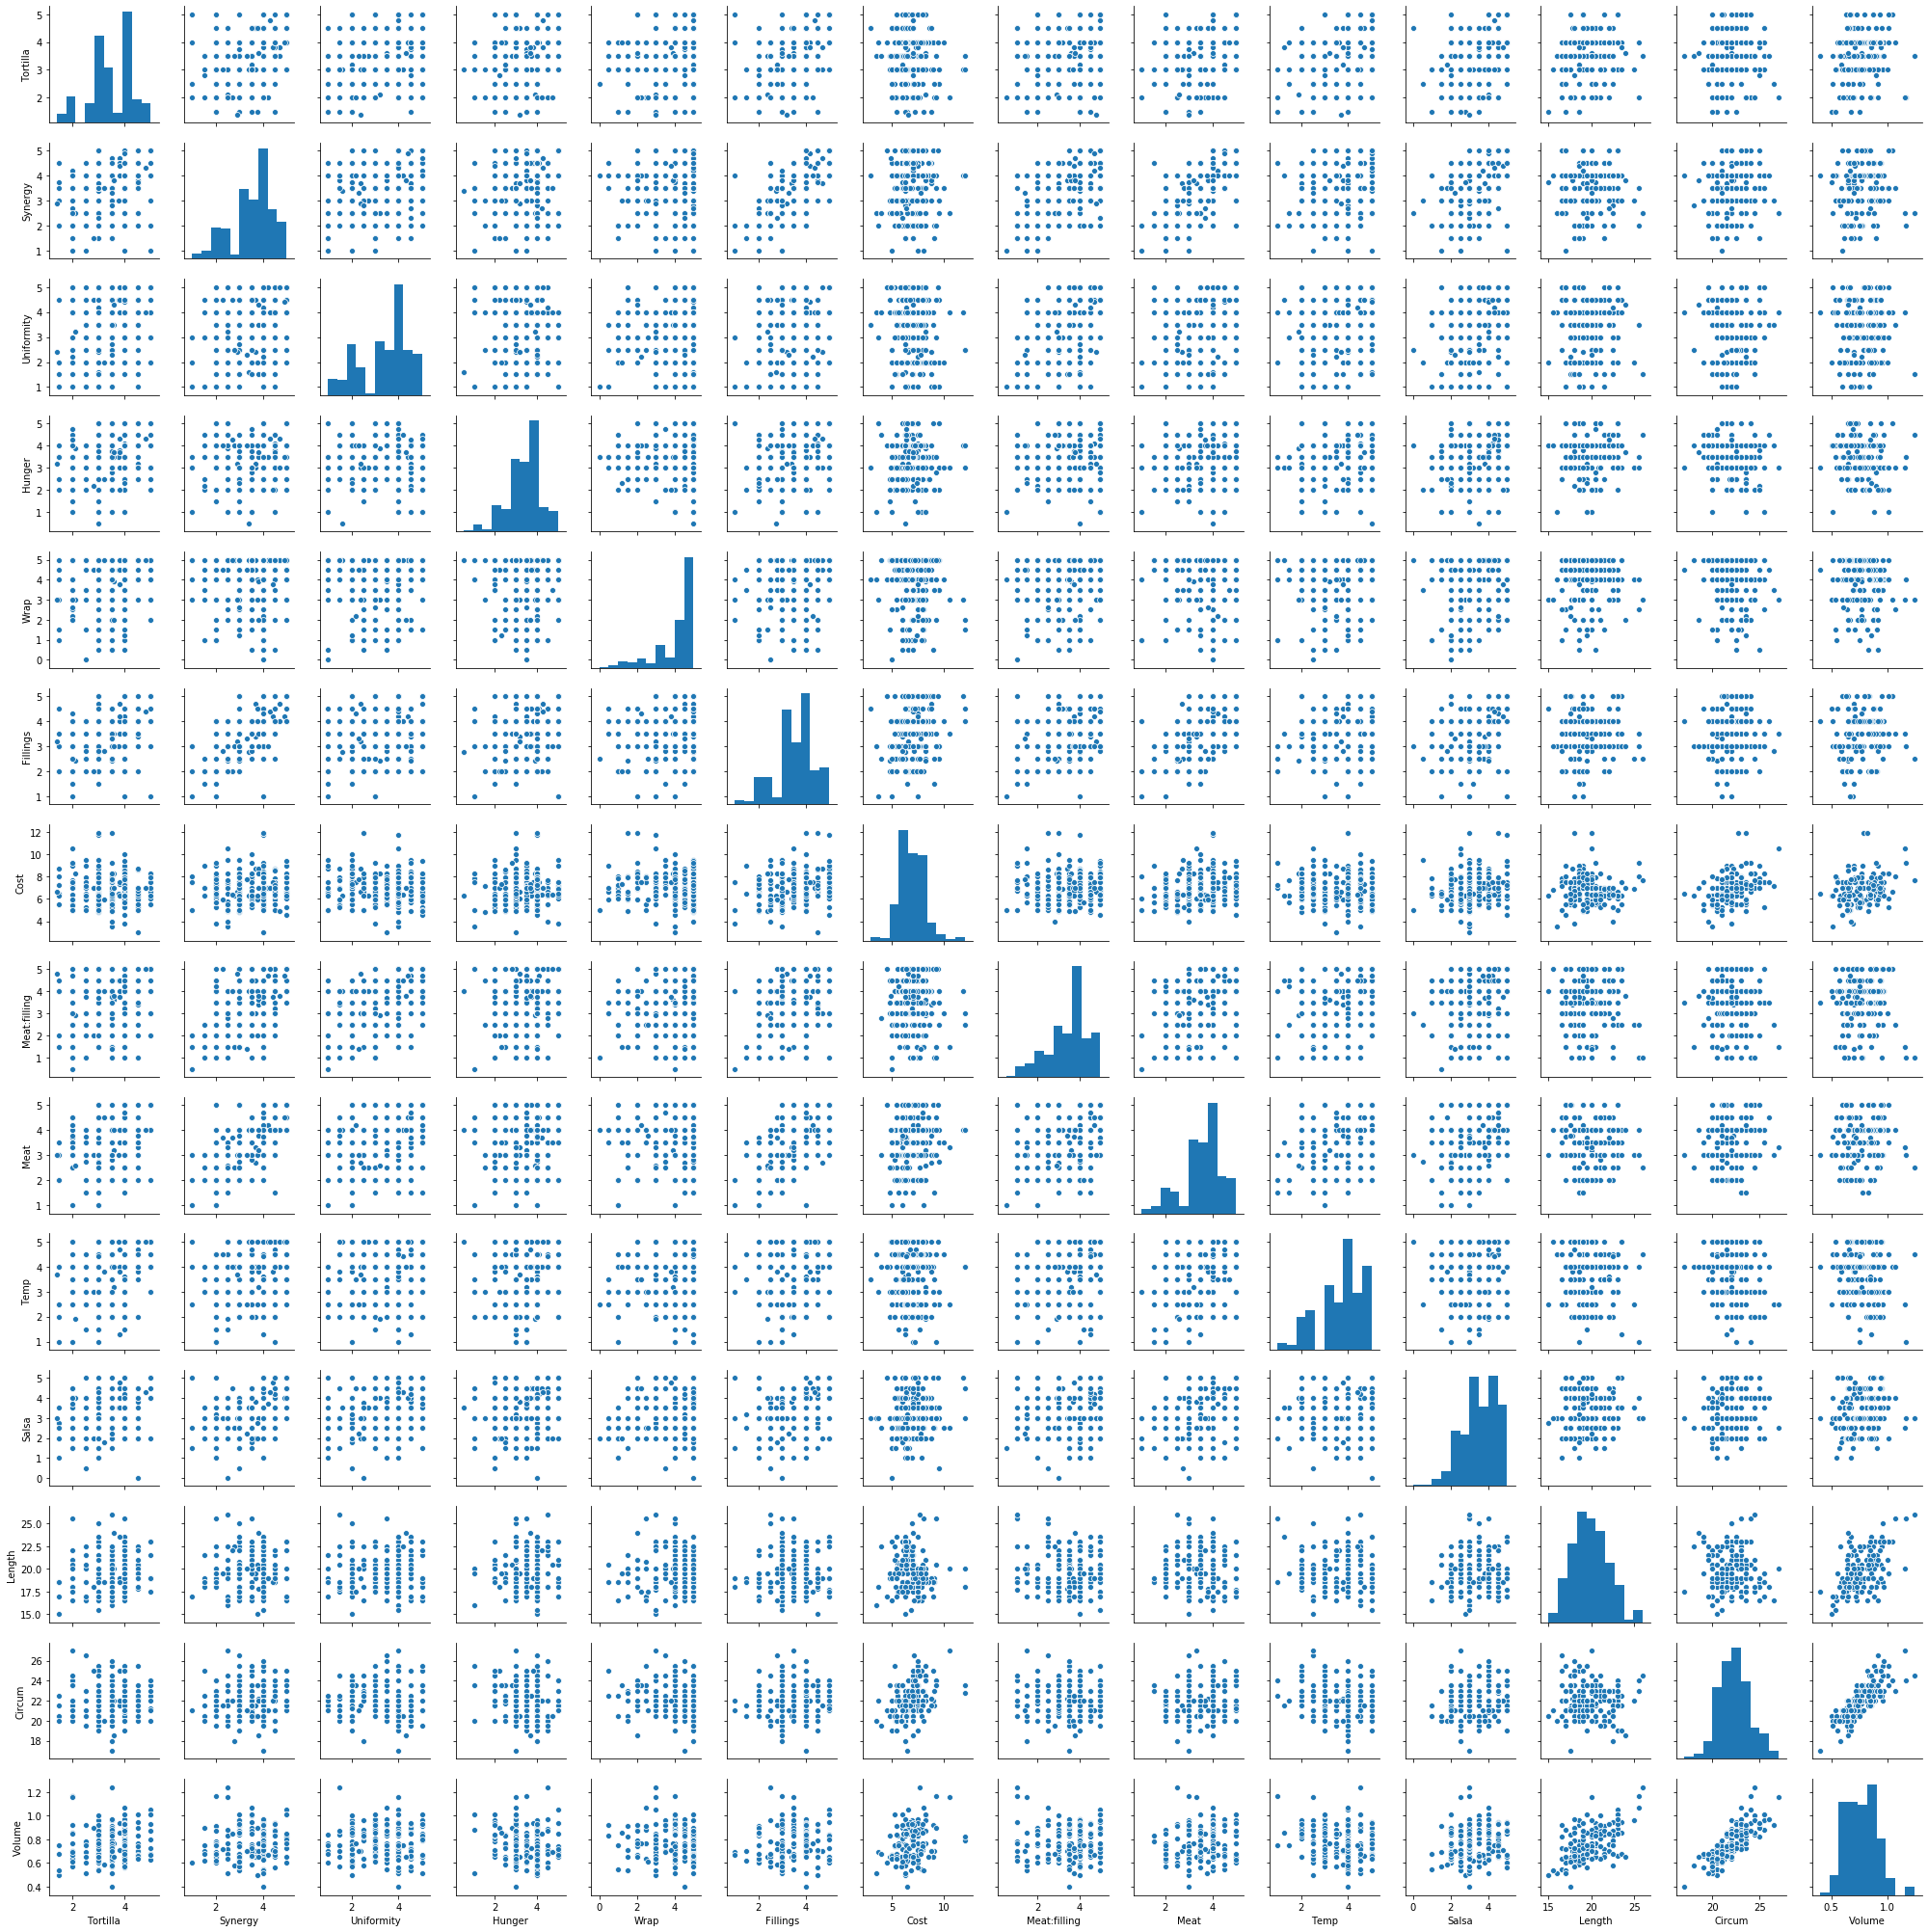

In [43]:
#Pairplot
import seaborn as sns
import matplotlib.pyplot as plt

cols = ['Burrito','Tortilla','Synergy','Uniformity', 
        'Hunger','Wrap','Fillings','Cost','Meat:filling', 
        'Meat','Temp','Salsa','Length','Circum','Volume']
sns.pairplot(train[cols], height=2)
plt.show()

## Creating Function to Apply Feature Engineering

In [ ]:
def engineer_features(X):
    #Avoid SettingWithCopyWarning
    X = X.copy()
    
    #Replace x's with 1 and NaNs with 0
    #Making an assumption that NaNs for the fillings are 0 and 
    #that the x's are meant to meant that these items were included. 
    
    cols = ['Salsa', 'Beef', 'Pico', 'Guac', 'Cheese', 'Fries', 'Sour cream']
    df[cols] = df[cols].fillna(0)
    df[cols] = df[cols].replace(r'X', '1')

In [ ]:
df.isnull().sum()

## Use scikit-learn for logistic regression.

## Get your model's validation accuracy. (Multiple times if you try multiple iterations.)

## Get your model's test accuracy. (One time, at the end.)